<a href="https://colab.research.google.com/github/OmarAshIbra/Database-Systems-Project/blob/main/The_Final_Stage_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
import torchvision.models as models
from collections import deque


In [ ]:
# Initialize global variables
# drone_speed = 0.21
# bus_speed = 0.75
# global_time = 0
# num_points = 4 # Example number of points
# # Define the number of trips between each station
# num_trips = num_points *3

# # Define the time duration for each trip (in seconds)
# trip_duration = 100

### Class to genrate the DATA

In [ ]:
# class to genrate all data:
class TransportationScheduler:
    def __init__(self, num_points, drone_speed, bus_speed,trip_duration,seed=None):
        self.num_points = num_points
        self.trip_duration = trip_duration
        self.num_trips = num_points
        self.drone_speed = drone_speed
        self.bus_speed = bus_speed
         # Set the seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        self.coordinates = torch.rand(num_points, 4)  # Random coordinates
        self.bus_coordinates = torch.tensor([[0.15, 0.85], [0.5, 0.5], [0.85, 0.15]])
        self.bus_schedules = self.generate_bus_schedules()

    def euclidean_distance(self, point1, point2):
        return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2).sqrt()

    def get_bus_coordinates(self):
        return self.bus_coordinates
    def get_bus_schedules(self):
        return self.bus_schedules

    def generate_bus_schedules(self):
        bus_schedules = []
        for bus_id, start_station in enumerate(self.bus_coordinates, 1):
            departures = np.arange(0, self.num_trips * self.trip_duration, 20)  # Departure times with 20 seconds interval
            destinations = []

            # Ensure that each destination is different from the start station
            for _ in range(self.num_trips):
                dest = torch.randint(1, len(self.bus_coordinates) + 1, (1,)).item()
                while dest == bus_id:  # Avoid trips to the same station
                    dest = torch.randint(1, len(self.bus_coordinates) + 1, (1,)).item()
                destinations.append(dest)

            arrival_times = []
            for i, dest in enumerate(destinations):
                dest_station = self.bus_coordinates[dest - 1]  # Coordinates of the destination station
                distance = self.euclidean_distance(start_station, dest_station)
                travel_time = distance / self.bus_speed  # Assuming constant speed
                arrival_times.append(departures[i] + travel_time.item())  # Arrival time = Departure time + Travel time

            # Combine departure times, destinations, and arrival times for the current bus
            bus_schedule = list(zip(departures.tolist(), destinations, arrival_times))
            bus_schedules.append(bus_schedule)
        return bus_schedules



    def closest_bus_station(self, point):
        min_distance = float('inf')
        closest_station = None
        for i, station in enumerate(self.bus_coordinates):
            distance = self.euclidean_distance(point, station)
            if distance < min_distance:
                min_distance = distance
                closest_station = i + 1
        return closest_station

    def calculate_distance(self, point1, point2):
        closest_station_point1 = self.closest_bus_station(point1)
        closest_station_point2 = self.closest_bus_station(point2)

        distance_point1_to_station = self.euclidean_distance(point1, self.bus_coordinates[closest_station_point1 - 1])
        distance_stations = self.euclidean_distance(self.bus_coordinates[closest_station_point1 - 1], self.bus_coordinates[closest_station_point2 - 1])
        distance_station_to_point2 = self.euclidean_distance(self.bus_coordinates[closest_station_point2 - 1], point2)

        total_distance = distance_point1_to_station + distance_stations + distance_station_to_point2
        return total_distance

    def calculate_optimal_order(self, root_point):
        distances_to_root = [(i, self.calculate_distance(root_point, point)) for i, point in enumerate(self.coordinates)]
        optimal_order = sorted(distances_to_root, key=lambda x: x[1])
        optimal_indices = [point[0] for point in optimal_order]
        self.coordinates = self.coordinates[optimal_indices]
        return self.coordinates

    def find_next_trip(self, global_time, bus_schedule, start_station, end_station):
        for departure, destination, arrival in bus_schedule[start_station - 1]:
            if destination == end_station and departure >= global_time:
                waiting_time = departure - global_time
                travel_time = arrival - departure
                return waiting_time, travel_time
        return float('inf'), float('inf')  # If no valid trip is found

    def calculate_times(self, root_point):
        global_time = 0
        root_index = 0  # Assuming root_point is always the first point

        # Set the root point's ti and tf to zero
        self.coordinates[root_index, 2] = 0
        self.coordinates[root_index, 3] = 0

        # Iterate through each point (excluding the root point)
        for i, point in enumerate(self.coordinates[1:], start=1):
            local_time = 0
            distance = self.euclidean_distance(root_point, point)

            # Closest bus stations
            closest_station_root = self.closest_bus_station(root_point)
            closest_station_point = self.closest_bus_station(point)

            if closest_station_root == closest_station_point:
                # If both points share the same closest bus station, go directly to the point
                travel_time = (distance / self.drone_speed)*2
                local_time += travel_time +5
                global_time += local_time

            else:
                # From root to closest bus station
                distance_root_to_station = self.euclidean_distance(root_point, self.bus_coordinates[closest_station_root - 1])
                time_root_to_station = distance_root_to_station / self.drone_speed
                local_time += time_root_to_station+5
                global_time += local_time

                # Find the next trip
                bus_schedule = self.bus_schedules[closest_station_root - 1]
                next_trip = next((trip for trip in bus_schedule if trip[1] == closest_station_point and trip[0] >= global_time), None)

                if next_trip:
                    waiting_time = next_trip[0] - global_time
                    travel_time = next_trip[2] - next_trip[0]
                    local_time += waiting_time + travel_time+5
                    global_time += local_time

                # From closest bus station to delivery point
                distance_station_to_point = self.euclidean_distance(self.bus_coordinates[closest_station_point - 1], point)
                time_station_to_point = distance_station_to_point / self.drone_speed
                local_time += time_station_to_point+5
                global_time += local_time

            # Update ti and tf
            self.coordinates[i, 2] = max(global_time - local_time, 0)
            self.coordinates[i, 3] = global_time + (distance / self.drone_speed)

        # Sort points by ti (excluding the root point)
        self.coordinates[1:] = self.coordinates[1:][self.coordinates[1:, 2].argsort()]

        return self.coordinates


    def get_optimal_order(self):


        return self.coordinates

    def get_shuffled_coordinates(self):
        root_point = self.coordinates[0]
        remaining_points = self.coordinates[1:]  # Exclude the root point
        shuffled_indices = np.random.permutation(len(remaining_points))
        shuffled_remaining_points = remaining_points[shuffled_indices]

        # Combine the root point with the shuffled remaining points
        shuffled_coordinates = torch.cat((root_point.unsqueeze(0), shuffled_remaining_points), dim=0)
        return shuffled_coordinates


## Test The Class

In [ ]:
# Example usage of the Class:
scheduler = TransportationScheduler(5,0.045,1.25,100)
root_point = scheduler.coordinates[0]
optimal_coordinates = scheduler.calculate_optimal_order(root_point)
updated_coordinates = scheduler.calculate_times(root_point)
poits= scheduler.get_optimal_order()
shuffled_coordinates = scheduler.get_shuffled_coordinates()


print("Updated Coordinates with Time Bounds:")
print(updated_coordinates)
print("Updated Coordinates with Time Bounds using get_optimal_order :")
print(updated_coordinates)
print("Shuffled Coordinates:")
print(shuffled_coordinates)

Updated Coordinates with Time Bounds:
tensor([[ 0.4976,  0.4140,  0.0000,  0.0000],
        [ 0.3619,  0.3616,  0.0000, 14.6990],
        [ 0.3812,  0.2149, 11.4660, 31.8444],
        [ 0.8569,  0.8362, 26.7183, 68.6775],
        [ 0.6347,  0.2038, 63.2695, 85.6904]])
Updated Coordinates with Time Bounds using get_optimal_order :
tensor([[ 0.4976,  0.4140,  0.0000,  0.0000],
        [ 0.3619,  0.3616,  0.0000, 14.6990],
        [ 0.3812,  0.2149, 11.4660, 31.8444],
        [ 0.8569,  0.8362, 26.7183, 68.6775],
        [ 0.6347,  0.2038, 63.2695, 85.6904]])
Shuffled Coordinates:
tensor([[ 0.4976,  0.4140,  0.0000,  0.0000],
        [ 0.6347,  0.2038, 63.2695, 85.6904],
        [ 0.3812,  0.2149, 11.4660, 31.8444],
        [ 0.8569,  0.8362, 26.7183, 68.6775],
        [ 0.3619,  0.3616,  0.0000, 14.6990]])


## Visualizing The Process


In [ ]:
# 1. Plot Points, Root, and Bus Stations with Optimal Order and Rank
def plot_points_and_order(scheduler):
    optimal_coordinates = scheduler.calculate_optimal_order(scheduler.coordinates[0])

    plt.figure(figsize=(10, 8))
    plt.scatter(optimal_coordinates[:, 0], optimal_coordinates[:, 1], c='green', s=100, marker='o')

    # Plot the order with distinguishable labels
    for idx, point in enumerate(optimal_coordinates):
        plt.text(point[0], point[1], f'{idx}', fontsize=12, ha='right' if idx == 0 else 'left', color='red' if idx == 0 else 'blue')

    plt.plot(optimal_coordinates[:, 0], optimal_coordinates[:, 1], c='orange', linestyle='--', label='Optimal Order')

    plt.title('Optimal Order of Points with Ranks')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

# 2. Plot Route for Each Point Individually and Combined
def plot_routes_individual(scheduler, point_idx):
    root_point = scheduler.coordinates[0, :2]
    point = scheduler.coordinates[point_idx, :2]
    bus_coordinates = scheduler.bus_coordinates

    # Function to plot the path between points
    def plot_path(start, end, color='k', linestyle='-', label=None):
        plt.plot([start[0], end[0]], [start[1], end[1]], color=color, linestyle=linestyle, label=label)

    plt.figure(figsize=(10, 8))

    # Plot the bus stations
    for i, bus_station in enumerate(bus_coordinates):
        plt.plot(bus_station[0], bus_station[1], 'gs')  # Plot bus stations in green squares
        plt.annotate(f'Bus {i+1}', (bus_station[0], bus_station[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the root point
    plt.plot(root_point[0], root_point[1], 'bo', label='Root')  # Plot root point in blue
    plt.annotate('Root', (root_point[0], root_point[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the point and its route
    closest_station_root = bus_coordinates[scheduler.closest_bus_station(root_point) - 1]
    closest_station_point = bus_coordinates[scheduler.closest_bus_station(point) - 1]

    plt.plot(point[0], point[1], 'ro')  # Plot delivery point in red
    plt.annotate(f'{point_idx}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the path from root to its closest bus station
    plot_path(root_point, closest_station_root, color='b', linestyle='--')

    # Plot the path from the closest bus station to the closest bus station to the point
    plot_path(closest_station_root, closest_station_point, color='g', linestyle='--')

    # Plot the path from the closest bus station to the point
    plot_path(closest_station_point, point, color='r', linestyle='--')

    plt.title(f"Route from Root to Point {point_idx}")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()



def plot_routes_combined(scheduler):
    root_point = scheduler.coordinates[0, :2]
    coordinates = scheduler.coordinates[:, :2]
    bus_coordinates = scheduler.bus_coordinates
    optimal_order_indices = range(len(scheduler.coordinates))

    # Function to plot the path between points
    def plot_path(start, end, color='k', linestyle='-', label=None):
        plt.plot([start[0], end[0]], [start[1], end[1]], color=color, linestyle=linestyle, label=label)

    plt.figure(figsize=(10, 8))

    # Plot the bus stations
    for i, bus_station in enumerate(bus_coordinates):
        plt.plot(bus_station[0], bus_station[1], 'gs')  # Plot bus stations in green squares
        plt.annotate(f'Bus {i+1}', (bus_station[0], bus_station[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the root point
    plt.plot(root_point[0], root_point[1], 'bo', label='Root')  # Plot root point in blue
    plt.annotate('Root', (root_point[0], root_point[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the points and their routes
    for idx in optimal_order_indices:
        point = coordinates[idx]
        closest_station_root = bus_coordinates[scheduler.closest_bus_station(root_point) - 1]
        closest_station_point = bus_coordinates[scheduler.closest_bus_station(point) - 1]

        plt.plot(point[0], point[1], 'ro')  # Plot delivery point in red
        plt.annotate(f'{idx}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

        # Plot the path from root to its closest bus station
        plot_path(root_point, closest_station_root, color='b', linestyle='--')

        # Plot the path from the closest bus station to the closest bus station to the point
        plot_path(closest_station_root, closest_station_point, color='g', linestyle='--')

        # Plot the path from the closest bus station to the point
        plot_path(closest_station_point, point, color='r', linestyle='--')

    plt.title("Optimal Delivery Route with Bus Stations")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

# 3. Modify the Time Windows (ti, tf) Plot
def plot_time_windows(scheduler):
    coordinates = scheduler.get_optimal_order()

    plt.figure(figsize=(10, 8))
    ti = coordinates[:, 2].numpy()
    tf = coordinates[:, 3].numpy()
    indices = np.arange(len(ti))

    plt.plot(indices, ti, 'ro-', label='ti (start time)')
    plt.plot(indices, tf, 'go-', label='tf (end time)')

    plt.xticks(indices, [f'Point {i}' for i in indices])
    plt.xlabel('Points')
    plt.ylabel('Time')
    plt.title('Time Windows for Each Point')
    plt.legend()
    plt.show()

# 4. Modify the Drone and Bus Distance Plot
def plot_drone_and_bus_distance(scheduler):
    drone_distances = []
    bus_distances = []

    for point in scheduler.coordinates[1:]:
        closest_station_root = scheduler.closest_bus_station(scheduler.coordinates[0])
        closest_station_point = scheduler.closest_bus_station(point)

        if closest_station_root == closest_station_point:
            # Direct distance by drone
            drone_distance = scheduler.euclidean_distance(scheduler.coordinates[0], point).item()
            bus_distance = 0
        else:
            # Distance by drone to station
            drone_distance = scheduler.euclidean_distance(scheduler.coordinates[0], scheduler.bus_coordinates[closest_station_root - 1]).item()
            # Distance by bus between stations
            bus_distance = scheduler.euclidean_distance(scheduler.bus_coordinates[closest_station_root - 1], scheduler.bus_coordinates[closest_station_point - 1]).item()
            # Distance by drone from station to point
            drone_distance += scheduler.euclidean_distance(scheduler.bus_coordinates[closest_station_point - 1], point).item()

        drone_distances.append(drone_distance)
        bus_distances.append(bus_distance)

    plt.figure(figsize=(10, 8))
    indices = np.arange(len(drone_distances))

    plt.plot(indices, drone_distances, 'bo-', label='Drone Distance')
    plt.plot(indices, bus_distances, 'go-', label='Bus Distance')

    plt.xticks(indices, [f'Point {i+1}' for i in indices])
    plt.xlabel('Points')
    plt.ylabel('Distance')
    plt.title('Distance Traveled by Drone and Bus for Each Point')
    plt.legend()
    plt.show()

# 5. Pie Chart Showing Time Contribution of Each Point
def plot_time_contribution_pie(scheduler):
    coordinates = scheduler.get_optimal_order()
    tf = coordinates[:, 3].numpy()

    plt.figure(figsize=(8, 8))
    plt.pie(tf, labels=[f'Point {i}' for i in range(len(tf))], autopct='%1.1f%%', startangle=140)
    plt.title('Time Contribution of Each Point')
    plt.show()

# 6. Plot Points, Root, and Bus Stations
def plot_points_and_stations(scheduler):
    plt.figure(figsize=(10, 8))

    # Plot bus stations
    bus_coordinates = scheduler.get_bus_coordinates()
    plt.scatter(bus_coordinates[:, 0], bus_coordinates[:, 1], c='blue', s=100, marker='s', label='Bus Stations')

    # Plot root point
    plt.scatter(scheduler.coordinates[0, 0], scheduler.coordinates[0, 1], c='red', s=100, marker='*', label='Root Point')

    # Plot other points
    plt.scatter(scheduler.coordinates[1:, 0], scheduler.coordinates[1:, 1], c='green', s=100, marker='o', label='Points')

    plt.title('Points, Root, and Bus Stations')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()


## The Problem space
We will plot the points (delivery points), root (starting point), and bus stations with different shapes and colors to distinguish them.

In [ ]:
# Calling the functions to plot the data
plot_points_and_stations(scheduler)


### The bus schedules

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.collections import BrokenBarHCollection

def plot_bus_schedules(scheduler):
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['tab:blue', 'tab:orange', 'tab:green']
    y_pos = 10  # Start position for the first bus
    height = 8  # Height of each bus bar

    for i, bus_schedule in enumerate(scheduler.bus_schedules):
        bars = []
        for departure, destination, arrival in bus_schedule:
            bars.append((departure, arrival - departure))

        # Add bars for this bus's schedule
        ax.add_collection(BrokenBarHCollection(bars, (y_pos, height), facecolors=colors[i]))

        # Label the bus
        ax.text(-5, y_pos + height / 2, f'Bus {i + 1}', va='center', ha='right', fontsize=12)
        y_pos += height + 5  # Move to the next bus

    ax.set_ylim(5, y_pos)
    ax.set_xlim(0, max([max([arrival for _, _, arrival in schedule]) for schedule in scheduler.bus_schedules]) + 10)
    ax.set_xlabel('Time')
    ax.set_ylabel('Bus ID')
    ax.set_title('Bus Schedules Timeline')
    plt.show()

# Example usage:

plot_bus_schedules(scheduler)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_detailed_bus_schedules(scheduler):
    fig, ax = plt.subplots(figsize=(14, 8))

    colors = ['tab:blue', 'tab:orange', 'tab:green']
    y_pos = 0  # Start position for the first bus
    bar_height = 0.4  # Height of each bar
    trip_height = 1.5  # Vertical space between trips

    for bus_id, bus_schedule in enumerate(scheduler.bus_schedules):
        for trip_id, (departure, destination, arrival) in enumerate(bus_schedule):
            start_station = scheduler.bus_coordinates[bus_id]
            end_station = scheduler.bus_coordinates[destination - 1]
            distance = scheduler.euclidean_distance(start_station, end_station).item()
            travel_time = arrival - departure

            # Plot the bar for this trip
            ax.barh(y_pos, travel_time, left=departure, height=bar_height, color=colors[bus_id], edgecolor='black')

            # Add text annotations for destination, travel time, and distance
            ax.text(departure + travel_time / 2, y_pos, f'Station {bus_id + 1} ➔ {destination}',
                    va='center', ha='center', color='black', fontsize=10, weight='bold')
            ax.text(departure + travel_time + 1, y_pos, f'Time: {travel_time:.2f} s\nDist: {distance:.2f} units',
                    va='center', ha='left', fontsize=9, color='black')

            y_pos += trip_height  # Move down for the next trip

    ax.set_ylim(-1, y_pos + 1)
    ax.set_xlim(0, max([arrival for schedule in scheduler.bus_schedules for _, _, arrival in schedule]) + 10)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Trips')
    ax.set_title('Detailed Bus Schedules: Departure Station, Destination, Travel Time, and Distance')
    plt.show()

# Example usage:
plot_detailed_bus_schedules(scheduler)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_enhanced_bus_schedule_timeline(scheduler):
    fig, ax = plt.subplots(figsize=(16, 9))

    color_map = plt.cm.get_cmap('Set2', len(scheduler.bus_schedules))

    # Plot each bus's schedule with enhanced design
    for bus_id, bus_schedule in enumerate(scheduler.bus_schedules):
        for trip_id, (departure, destination, arrival) in enumerate(bus_schedule):
            y = bus_id + 1

            # Plot the timeline as a bold line with circular markers at each end
            ax.plot([departure, arrival], [y, y], color=color_map(bus_id), lw=10, solid_capstyle='round')

            # Mark the departure and arrival with circular markers
            ax.plot(departure, y, 'o', color='white', markersize=12, markeredgecolor=color_map(bus_id), markeredgewidth=3)
            ax.plot(arrival, y, 'o', color='white', markersize=12, markeredgecolor=color_map(bus_id), markeredgewidth=3)

            # Add text for the station and destination
            ax.text(departure, y + 0.15, f'Station {bus_id + 1}', va='bottom', ha='right', fontsize=12, weight='bold', color='black')
            ax.text(arrival, y - 0.15, f'Station {destination}', va='top', ha='left', fontsize=12, weight='bold', color='black')

    # Customize the plot's appearance
    ax.set_yticks(range(1, len(scheduler.bus_schedules) + 1))
    ax.set_yticklabels([f'Bus {i+1}' for i in range(len(scheduler.bus_schedules))], fontsize=14, weight='bold')
    ax.set_xlabel('Time (s)', fontsize=16, weight='bold')
    ax.set_title('Enhanced Bus Schedule Timeline', fontsize=20, weight='bold', color='darkblue')

    # Remove unnecessary spines and add a grid for better clarity
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='gray')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_enhanced_bus_schedule_timeline(scheduler)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import datetime

def visualize_bus_schedule_timeline(bus_schedules, bus_coordinates):
    fig, ax = plt.subplots(figsize=(15, 8))

    # Define colors for the bus lines and stations
    bus_colors = ['#FF5733', '#33FF57', '#3357FF']
    station_colors = ['#FFD700', '#ADFF2F', '#FF69B4']

    # Set the date format on the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    plt.xticks(rotation=45, ha='right')

    for i, bus_schedule in enumerate(bus_schedules):
        for trip in bus_schedule:
            departure_time = datetime.datetime(2024, 8, 9, 0, 0) + datetime.timedelta(seconds=trip[0])
            arrival_time = datetime.datetime(2024, 8, 9, 0, 0) + datetime.timedelta(seconds=trip[2])
            duration = arrival_time - departure_time

            # Plot the timeline
            ax.plot([departure_time, arrival_time], [i, i], color=bus_colors[i % len(bus_colors)], lw=4, label=f'Bus {i+1}' if trip == bus_schedule[0] else "")

            # Add station markers
            start_station = trip[1] - 1
            ax.scatter(departure_time, i, color=station_colors[start_station], s=200, zorder=5)
            ax.scatter(arrival_time, i, color=station_colors[start_station], s=200, zorder=5)

            # Annotate the travel time and distance
            ax.text(departure_time + duration/2, i + 0.1, f'{int(duration.total_seconds()*60)} min',
                    ha='center', va='center', fontsize=12, color='white', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.3'))

            ax.text(departure_time + duration/2, i - 0.3, f'Station {start_station + 1} → {trip[1]}',
                    ha='center', va='center', fontsize=10, color=bus_colors[i % len(bus_colors)], bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

    # Add labels and title
    ax.set_yticks(range(len(bus_schedules)))
    ax.set_yticklabels([f'Bus {i+1}' for i in range(len(bus_schedules))])
    ax.set_xlabel('Time', fontsize=14)
    ax.set_title('Bus Schedule Timeline', fontsize=18, fontweight='bold')

    # Remove legend duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example Usage
bus_schedules = scheduler.get_bus_schedules()
print(bus_schedules)
print("\n \n \n \n")
bus_coordinates = scheduler.get_bus_coordinates()
visualize_bus_schedule_timeline(bus_schedules, bus_coordinates)


In [ ]:
plot_points_and_order(scheduler)


In [ ]:
plot_routes_combined(scheduler)

In [ ]:
plot_time_windows(scheduler)

In [ ]:
plot_drone_and_bus_distance(scheduler)

In [ ]:
plot_time_contribution_pie(scheduler)


## Build  The DQN Model

In [ ]:
import numpy as np

class HybridNetworkEnv:
    def __init__(self):
        self.drone_speed = 0.045
        self.bus_speed = 1.25
        self.battery_time = 2  # battery life
        self.num_points = 4
        self.global_time = 0
        self.trip_duration = 80


    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
            A numpy array of size (num_points, 4) containing the coordinates (x, y)
            and initial time window (ti, tf) for each point.
        """
        self.global_time = 0
        scheduler = TransportationScheduler(self.num_points, self.drone_speed, self.bus_speed, self.trip_duration)  # Create the data

        self.bus_coordinates = scheduler.get_bus_coordinates()
        self.root= scheduler.coordinates[0].clone()
        self.optimal_coordinates = scheduler.calculate_optimal_order(self.root).clone()
        self.updated_coordinates = scheduler.calculate_times(self.root).clone()
        self.coordinates = scheduler.get_shuffled_coordinates().clone()
        self.remaining_deliveries = list(range(1, len(self.coordinates)))  # Delivery indices (excluding depot)
        self.bus_schedules = scheduler.generate_bus_schedules()
        self.root_location = self.coordinates[0].clone()
        self.done = False

        print("the Optimal order is \n ",self.updated_coordinates)
        print("the shuffled point is \n ",self.coordinates)

        return self.root_location, self.remaining_deliveries

    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1[:2] - point2[:2])

    def closest_bus_station(self, point):
        min_distance = float('inf')
        closest_station = None
        for i, station in enumerate(self.bus_coordinates):
            distance = self.euclidean_distance(point, station)
            if distance < min_distance:
                min_distance = distance
                closest_station = i + 1
        return closest_station

    def find_next_trip(self, global_time, bus_schedule, start_station, end_station):
        for departure, destination, arrival in bus_schedule:
            if destination == end_station and departure >= global_time:
                waiting_time = departure - global_time
                travel_time = arrival - departure
                return waiting_time, travel_time
        return float('inf'), float('inf')  # If no valid trip is found

    def step(self, action):
      reward = 0
      chosen_point = self.coordinates[action]
      # Find the minimum `ti` among all remaining points
      min_ti = min([point[2] for point in self.coordinates[self.remaining_deliveries]])
      max_tf = max([point[3] for point in self.coordinates[self.remaining_deliveries]])



      # Check if the chosen action is valid
      if action not in self.remaining_deliveries:
          return self.root_location, -1000, self.remaining_deliveries, True

      # Calculate the direct travel time to the chosen point using the drone
      distance_to_point = self.euclidean_distance(self.root_location, chosen_point)
      travel_time_drone = distance_to_point / self.drone_speed

      # Check if the drone can directly reach the point without exceeding battery life
      if travel_time_drone <= (self.battery_time / 2):
          reward = 10
          self.global_time += travel_time_drone
          self.battery_time -= travel_time_drone
          self.remaining_deliveries.remove(action)
          self.done = len(self.remaining_deliveries) == 0
      else:
          # Find the closest bus stations to both the root and the chosen point
          closest_station_root = self.closest_bus_station(self.root_location)
          closest_station_point = self.closest_bus_station(chosen_point)

          # If the root and the chosen point share the same closest bus station, travel directly to the point
          if closest_station_root == closest_station_point:
              reward = 10
              self.global_time += travel_time_drone
              self.battery_time -= travel_time_drone
              self.remaining_deliveries.remove(action)
              self.done = len(self.remaining_deliveries) == 0
          else:
              # Otherwise, use the bus to travel between stations
              distance_root_to_station = self.euclidean_distance(self.root_location, self.bus_coordinates[closest_station_root - 1])
              local_time = distance_root_to_station / self.drone_speed

              # Find the next bus trip from the closest station to the destination station
              waiting_time, travel_time_bus = self.find_next_trip(
                  self.global_time,
                  self.bus_schedules[closest_station_root - 1],
                  closest_station_root,
                  closest_station_point
              )
               # If global_time is less than the minimum `ti`, update global_time to match that value
              if self.global_time <= min_ti:
                  self.global_time = min_ti
                  print(f"Global time updated to {self.global_time} to match the earliest ti of the remaining points")
              if (self.global_time+local_time) > max_tf:
                # If no valid bus trip is found, terminate with a penalty
                  self.done = True
                  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point
                  return penalty_tensor, -100, self.remaining_deliveries, self.done


              if waiting_time != float('inf') and travel_time_bus != float('inf'):
                  local_time += waiting_time + travel_time_bus
                  distance_point_to_station = self.euclidean_distance(chosen_point, self.bus_coordinates[closest_station_point - 1])
                  local_time += (distance_point_to_station / self.drone_speed)+self.global_time


                  # Check if the delivery is within the time window
                  if local_time >= chosen_point[2] and local_time <= chosen_point[3]:
                      reward = 10
                      self.global_time += local_time
                      self.remaining_deliveries.remove(action)
                      self.done = len(self.remaining_deliveries) == 0
                  else:

                      reward = -10
              else:
                  # If no valid bus trip is found, terminate with a penalty
                  self.done = True
                  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point
                  return penalty_tensor, -100, self.remaining_deliveries, self.done

      return chosen_point, reward, self.remaining_deliveries, self.done



# Example usage
env = HybridNetworkEnv()
state = env.reset()
action = env.remaining_deliveries[2]  # Example action (selecting the third delivery point)
next_state, reward, remaining_deliveries, done = env.step(action)
print(f"Next State: {next_state}, Reward: {reward}, Remaining Deliveries: {remaining_deliveries}, Done: {done}")


the Optimal order is 
  tensor([[3.5994e-01, 2.1277e-01, 0.0000e+00, 0.0000e+00],
        [5.3500e-02, 4.0052e-01, 0.0000e+00, 2.8959e+01],
        [3.1319e-01, 8.9782e-01, 3.3074e+01, 6.9212e+01],
        [6.5759e-03, 9.7387e-01, 6.6055e+01, 1.0601e+02]])
the shuffled point is 
  tensor([[3.5994e-01, 2.1277e-01, 0.0000e+00, 0.0000e+00],
        [5.3500e-02, 4.0052e-01, 0.0000e+00, 2.8959e+01],
        [3.1319e-01, 8.9782e-01, 3.3074e+01, 6.9212e+01],
        [6.5759e-03, 9.7387e-01, 6.6055e+01, 1.0601e+02]])
Global time updated to 0.0 to match the earliest ti of the remaining points
Next State: tensor([6.5759e-03, 9.7387e-01, 6.6055e+01, 1.0601e+02]), Reward: -10, Remaining Deliveries: [1, 2, 3], Done: False


In [ ]:
import random

# TEST THE ENVIRONMENT
# Initialize the environment
env = HybridNetworkEnv()

# Function to run a single episode
def run_episode(env, max_steps=8):
    state, remaining_deliveries = env.reset()
    total_reward = 0

    for step in range(max_steps):
        # Randomly select an action from the remaining deliveries
        if not remaining_deliveries:
            break
        action = random.choice(remaining_deliveries)

        # Take a step in the environment
        chosen_point, reward, remaining_deliveries, done = env.step(action)
        total_reward += reward

        # Print the result of the step
        print(f"Step: {step + 1}")
        print(f"Action: {action}")
        print(f"Chosen Point: {chosen_point}")
        print(f"Reward: {reward}")
        print(f"Remaining Deliveries: {remaining_deliveries}")
        print(f"Done: {done}")
        print()

        if done:
            break

    print(f"Total reward: {total_reward}")

# Run a single episode
run_episode(env)


the Optimal order is 
  tensor([[9.1542e-01, 3.3683e-01, 0.0000e+00, 0.0000e+00],
        [9.1843e-01, 4.0436e-01, 0.0000e+00, 5.0000e+00],
        [5.5957e-01, 4.1969e-02, 5.0000e+00, 4.4001e+01],
        [5.5737e-01, 4.9576e-01, 4.3521e+01, 6.8929e+01]])
the shuffled point is 
  tensor([[9.1542e-01, 3.3683e-01, 0.0000e+00, 0.0000e+00],
        [5.5737e-01, 4.9576e-01, 4.3521e+01, 6.8929e+01],
        [9.1843e-01, 4.0436e-01, 0.0000e+00, 5.0000e+00],
        [5.5957e-01, 4.1969e-02, 5.0000e+00, 4.4001e+01]])
Step: 1
Action: 2
Chosen Point: tensor([0.9184, 0.4044, 0.0000, 5.0000])
Reward: 10
Remaining Deliveries: [1, 3]
Done: False

Step: 2
Action: 3
Chosen Point: tensor([5.5957e-01, 4.1969e-02, 5.0000e+00, 4.4001e+01])
Reward: 10
Remaining Deliveries: [1]
Done: False

Global time updated to 43.52056121826172 to match the earliest ti of the remaining points
Step: 3
Action: 1
Chosen Point: tensor([ 0.5574,  0.4958, 43.5206, 68.9290])
Reward: 10
Remaining Deliveries: []
Done: True

Total

In [ ]:
#Agent

# Define the neural network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=10000, batch_size=64, target_update=10):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.lr = lr
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.target_update = target_update
        self.learn_step_counter = 0

        self.q_network = QNetwork(state_dim, action_dim)
        self.target_network = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_q_values(self, state):
        with torch.no_grad():
            q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
        return q_values.numpy()
    def select_action(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
                q_values_valid = q_values[valid_actions]
                return valid_actions[torch.argmax(q_values_valid).item()]

    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = self.criterion(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.learn_step_counter % self.target_update == 0:
            self.update_target_network()

        self.learn_step_counter += 1

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def train(self, env, episodes):
      self.q_values_history = []  # To store states and Q-values
      for episode in range(episodes):
          state, remaining_deliveries = env.reset()
          state = state.numpy()
          total_reward = 0
          done = False

          while not done:
              if not remaining_deliveries:
                  break  # No valid actions, end episode
              action = self.select_action(state, remaining_deliveries)
              chosen_point, reward, remaining_deliveries, done= env.step(action)
              next_state = chosen_point.numpy()
              # Store Q-values for the current state
              q_values = self.get_q_values(state)
              self.q_values_history.append((state, q_values))

              self.store_transition(state, action, reward, next_state, done)
              self.experience_replay()

              state = next_state
              total_reward += reward

              # Debugging prints
              print(f"Episode: {episode+1}, Action: {action}, Reward: {reward}, Done: {done}, Valid Actions: {remaining_deliveries}")

          print(f"Episode {episode+1}: Total Reward: {total_reward}")



In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np


# Initialize the environment
env = HybridNetworkEnv()

# Initialize the agent
state_dim = 4  # Adjust according to your state dimension
action_dim = env.num_points - 1  # Number of delivery points (excluding the depot)
agent = DQNAgent(state_dim, action_dim)

# Train the agent
agent.train(env, episodes=10)

# Visualize Q-values after training
def visualize_q_values_from_training(agent):
    for i, (state, q_values) in enumerate(agent.q_values_history):
        print(f"State {i+1}: {state}")
        print(f"Q-values: {q_values}")
        plt.bar(range(len(q_values)), q_values)
        plt.xlabel('Actions')
        plt.ylabel('Q-values')
        plt.title(f'Q-values for State {i+1}')
        plt.show()
# Function to run a single episode and test the model
def run_episode(env, agent, max_steps=5):
    state, remaining_deliveries = env.reset()
    state = state.numpy()
    total_reward = 0
    done = False

    for step in range(max_steps):
        if not remaining_deliveries:
            break
        action = agent.select_action(state, remaining_deliveries)
        chosen_point, reward, remaining_deliveries, done = env.step(action)
        next_state = chosen_point.numpy()

        state = next_state
        total_reward += reward

        # Print the result of the step
        print(f"Step: {step + 1}")
        print(f"Action: {action}")
        print(f"State: {state}")
        print(f"Reward: {reward}")
        print(f"Done: {done}")
        print()

        if done:
            break

    print(f"Total reward: {total_reward}")

# Run a single episode to test the trained model
run_episode(env, agent)
# visualize_q_values_from_training(agent)

the Optimal order is 
  tensor([[  0.8549,   0.4180,   0.0000,   0.0000],
        [  0.9686,   0.5187,   0.0000,   5.0000],
        [  0.7851,   0.5966,  39.0023,  75.5179],
        [  0.5489,   0.9592,  84.6936, 126.0123]])
the shuffled point is 
  tensor([[  0.8549,   0.4180,   0.0000,   0.0000],
        [  0.9686,   0.5187,   0.0000,   5.0000],
        [  0.7851,   0.5966,  39.0023,  75.5179],
        [  0.5489,   0.9592,  84.6936, 126.0123]])
Global time updated to 0.0 to match the earliest ti of the remaining points
Episode: 1, Action: 2, Reward: -10, Done: False, Valid Actions: [1, 2, 3]
Global time updated to 0.0 to match the earliest ti of the remaining points
Episode: 1, Action: 2, Reward: -10, Done: False, Valid Actions: [1, 2, 3]
Global time updated to 0.0 to match the earliest ti of the remaining points
Episode: 1, Action: 3, Reward: -10, Done: False, Valid Actions: [1, 2, 3]
Global time updated to 0.0 to match the earliest ti of the remaining points
Episode: 1, Action: 3, 

<ipython-input-6-32550230feeb>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point
<ipython-input-6-32550230feeb>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point


the Optimal order is 
  tensor([[9.1744e-01, 2.9183e-01, 0.0000e+00, 0.0000e+00],
        [6.3433e-01, 1.6248e-01, 0.0000e+00, 5.0000e+00],
        [3.1826e-01, 2.4304e-01, 3.5197e+01, 7.4835e+01],
        [2.2626e-02, 7.8086e-01, 7.7387e+01, 1.1474e+02]])
the shuffled point is 
  tensor([[9.1744e-01, 2.9183e-01, 0.0000e+00, 0.0000e+00],
        [6.3433e-01, 1.6248e-01, 0.0000e+00, 5.0000e+00],
        [3.1826e-01, 2.4304e-01, 3.5197e+01, 7.4835e+01],
        [2.2626e-02, 7.8086e-01, 7.7387e+01, 1.1474e+02]])
Global time updated to 0.0 to match the earliest ti of the remaining points
Step: 1
Action: 2
State: [ 0.31825697  0.24303532 35.196556   74.835266  ]
Reward: -10
Done: False

Step: 2
Action: 1
State: [0.6343348  0.16247523 0.         5.        ]
Reward: 10
Done: False

Global time updated to 35.196556091308594 to match the earliest ti of the remaining points
Step: 3
Action: 3
State: [2.2626221e-02 7.8086245e-01 7.7387329e+01 1.1473790e+02]
Reward: -10
Done: False

Global time upd

# 1. Evaluate the Model

### 1.1. Run Multiple Test Episodes

In [ ]:
def evaluate_agent(env, agent, num_episodes=10):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Get the valid actions for the current state
            valid_actions = env.remaining_deliveries

            # Select an action using the agent, ensuring exploration is disabled
            action = agent.select_action(state, valid_actions)

            # Take the action in the environment
            next_state, reward, done, _ = env.step(action)

            # Update the total reward and move to the next state
            total_reward += reward
            state = next_state

        # Store the total reward for this episode
        rewards.append(total_reward)

    return rewards



### 1.2. Analyze the Results

In [ ]:
def analyze_results(rewards):
    print(f"Average Reward: {sum(rewards)/len(rewards)}")
    print(f"Max Reward: {max(rewards)}")
    print(f"Min Reward: {min(rewards)}")

### 1.3. Visualize the Results

the Optimal order is 
  tensor([[  0.8722,   0.3384,   0.0000,   0.0000],
        [  0.5798,   0.4863,  54.6110, 114.0880],
        [  0.3476,   0.4091, 116.0217, 145.9427],
        [  0.3001,   0.8680, 143.3951, 178.2947]])
the shuffled point is 
  tensor([[  0.8722,   0.3384,   0.0000,   0.0000],
        [  0.3476,   0.4091, 116.0217, 145.9427],
        [  0.3001,   0.8680, 143.3951, 178.2947],
        [  0.5798,   0.4863,  54.6110, 114.0880]])
Global time updated to 54.61102294921875 to match the earliest ti of the remaining points
the Optimal order is 
  tensor([[2.5395e-01, 3.6864e-01, 0.0000e+00, 0.0000e+00],
        [8.0979e-01, 7.3769e-01, 0.0000e+00, 6.2614e+01],
        [6.0062e-01, 9.1285e-01, 4.3409e+01, 1.0118e+02],
        [3.0869e-02, 3.6334e-01, 8.3590e+01, 8.8590e+01]])
the shuffled point is 
  tensor([[2.5395e-01, 3.6864e-01, 0.0000e+00, 0.0000e+00],
        [6.0062e-01, 9.1285e-01, 4.3409e+01, 1.0118e+02],
        [8.0979e-01, 7.3769e-01, 0.0000e+00, 6.2614e+01],
   

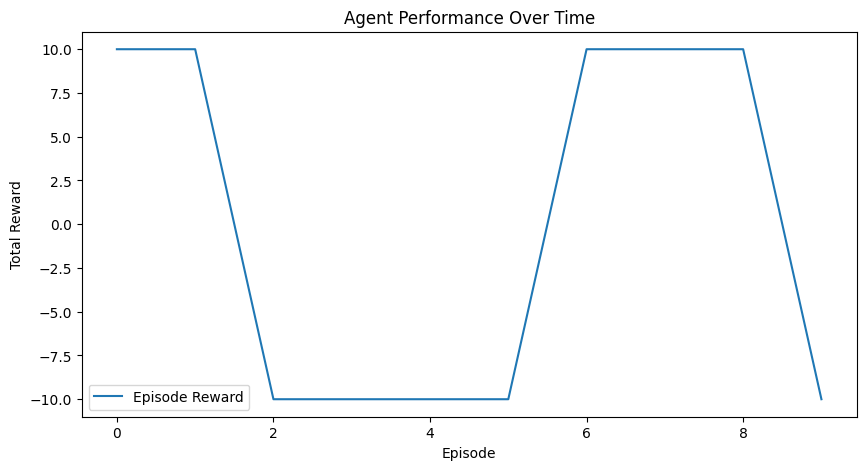

In [ ]:
import matplotlib.pyplot as plt

def visualize_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Agent Performance Over Time")
    plt.legend()
    plt.show()

# Example usage:
rewards = evaluate_agent(env, agent)
analyze_results(rewards)
visualize_rewards(rewards)


# 2. Refine the Model


In [ ]:
# Function to train and evaluate the agent
def train_and_evaluate(agent, env, episodes=1):
    agent.train(env, episodes=episodes)
    rewards = evaluate_agent(env, agent)
    return rewards

# Define hyperparameters to experiment with
learning_rates = [0.001, 0.0001 ] #0.001, 0.0001, 0.00001
gammas = [0.99, 0.95] #0.99, 0.95, 0.90
epsilon_decays = [0.995, 0.99]#0.995, 0.99, 0.98

# Dictionary to store results
results = {}

for lr in learning_rates:
    for gamma in gammas:
        for epsilon_decay in epsilon_decays:
            print(f"Training with lr={lr}, gamma={gamma}, epsilon_decay={epsilon_decay}")
            # Initialize the environment
            env = HybridNetworkEnv()

            # Initialize the agent
            state_dim = 4  # Adjust according to your state dimension
            action_dim = env.num_points - 1  # Number of delivery points (excluding the depot)
            agent = DQNAgent(
                state_dim,
                action_dim=action_dim,
                lr=lr,
                gamma=gamma,
            )
            rewards = train_and_evaluate(agent, env)
            results[(lr, gamma, epsilon_decay)] = rewards

# Function to visualize results
def visualize_results(results):
    for (lr, gamma, epsilon_decay), rewards in results.items():
        plt.plot(rewards, label=f'LR: {lr}, Gamma: {gamma}, Decay: {epsilon_decay}')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards for Different Hyperparameters')
    plt.legend()
    plt.show()

# Visualize the results
visualize_results(results)

